In [1]:
from navigation import *
from PIL import Image, ImageDraw
from typing import Any
from datetime import datetime
from openai import OpenAI
import json

In [2]:
import math
def smart_resize(
    height: int,
    width: int,
    factor: int = 28,
    min_pixels: int = 56 * 56,
    max_pixels: int = 14 * 14 * 4 * 1280,
) -> tuple[int, int]:
    """Copied from https://github.com/huggingface/transformers/blob/v4.52.4/src/transformers/models/qwen2_vl/image_processing_qwen2_vl.py#L55.

    Rescales the image so that the following conditions are met:
      - Both dimensions (height and width) are divisible by 'factor'.
      - The total number of pixels is within the range ['min_pixels', 'max_pixels'].
      - The aspect ratio of the image is maintained as closely as possible.
    """
    if height < factor or width < factor:
        raise ValueError(
            f"height:{height} or width:{width} must be larger than factor:{factor}"
        )
    elif max(height, width) / min(height, width) > 200:
        raise ValueError(
            f"absolute aspect ratio must be smaller than 200, got {max(height, width) / min(height, width)}"
        )
    h_bar = round(height / factor) * factor
    w_bar = round(width / factor) * factor
    if h_bar * w_bar > max_pixels:
        beta = math.sqrt((height * width) / max_pixels)
        h_bar = math.floor(height / beta / factor) * factor
        w_bar = math.floor(width / beta / factor) * factor
    elif h_bar * w_bar < min_pixels:
        beta = math.sqrt(min_pixels / (height * width))
        h_bar = math.ceil(height * beta / factor) * factor
        w_bar = math.ceil(width * beta / factor) * factor
    return h_bar, w_bar

(1280, 800)
(1260, 784)


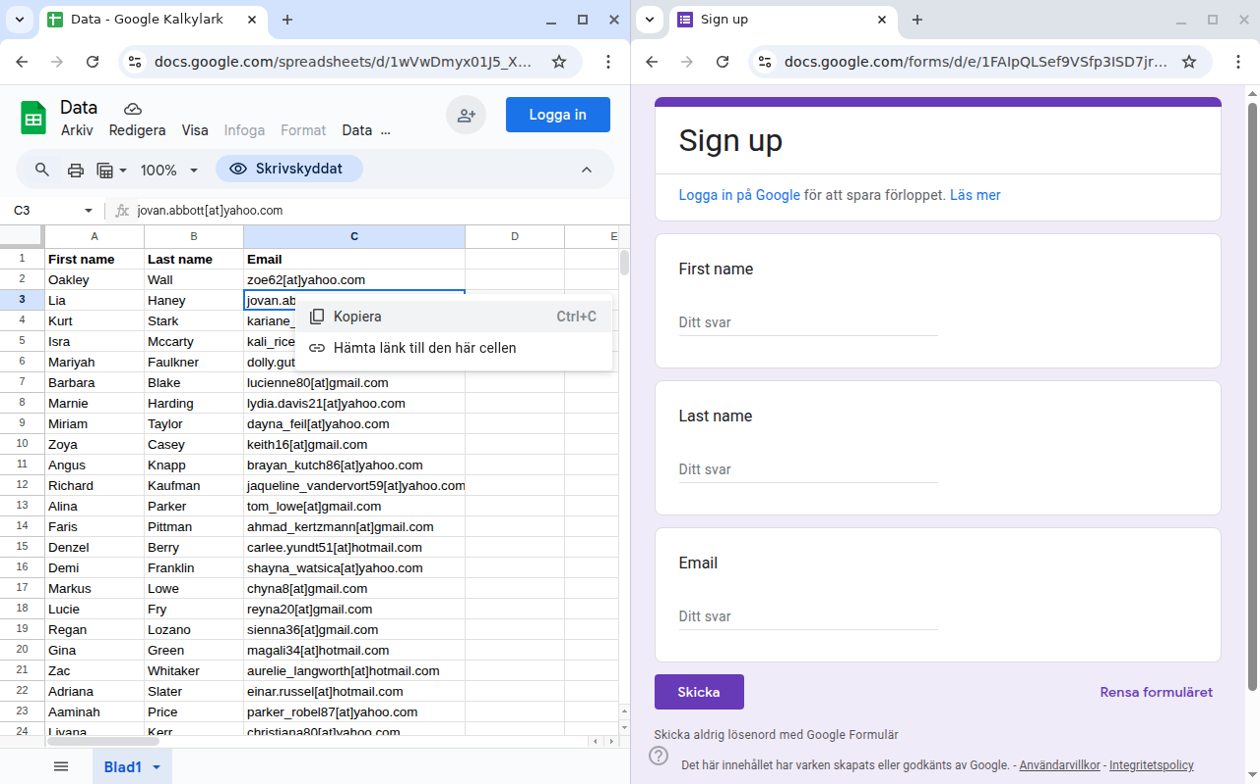

In [3]:
image = Image.open("/tmp/screen.png")
print(image.size)
# Resize the image so that predicted absolute coordinates match the size of the image.
resized_height, resized_width = smart_resize(height=image.height, width=image.width)
image = image.resize(size=(resized_width, resized_height), resample=None)
print(image.size)
image

In [20]:
def build_navigation_task_messages(
    task: str, image: Image.Image, image_format: str, step: int = 1
) -> list[dict[str, Any]]:
    system_prompt = SYSTEM_PROMPT.format(
        output_format=NavigationStep.model_json_schema(),
        timestamp=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    )
    image_url = convert_image_to_base64_url(image, image_format)
    return [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": system_prompt},
            ],
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"<task>\n{task}\n</task>\n"},
                {"type": "text", "text": f"<observation step={step}>\n"},
                {"type": "text", "text": "<screenshot>\n"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url,
                    },
                },
                {"type": "text", "text": "\n</screenshot>\n"},
                {"type": "text", "text": "\n</observation>\n"},
            ],
        },
    ]

LOCALIZATION_TASK_PROMPT = f"""Localize an element on the GUI image according to the provided target and output a click position.
     * You must output a valid JSON following the format: {ClickAbsoluteAction.model_json_schema()}
     Your target is:"""

def build_messages(
    task: str, image: Image.Image, image_format: str
) -> list:
    """Build the messages for the localization task.

    Args:
        image: Image providing context for the localization task.
        instruction: User instruction for the localization task.
        format: PIL image format (see https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html).

    Returns:
        List of messages for the localization task.
    """
    image_url = convert_image_to_base64_url(image=image, format=image_format)
    return [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url", 
                    "image_url": {
                        "url": image_url,
                    },
                },
                {"type": "text", "text": f"{LOCALIZATION_TASK_PROMPT}\n{task}"},
            ],
        }
    ]

{"action": "click_absolute", "x": 316, "y": 317}


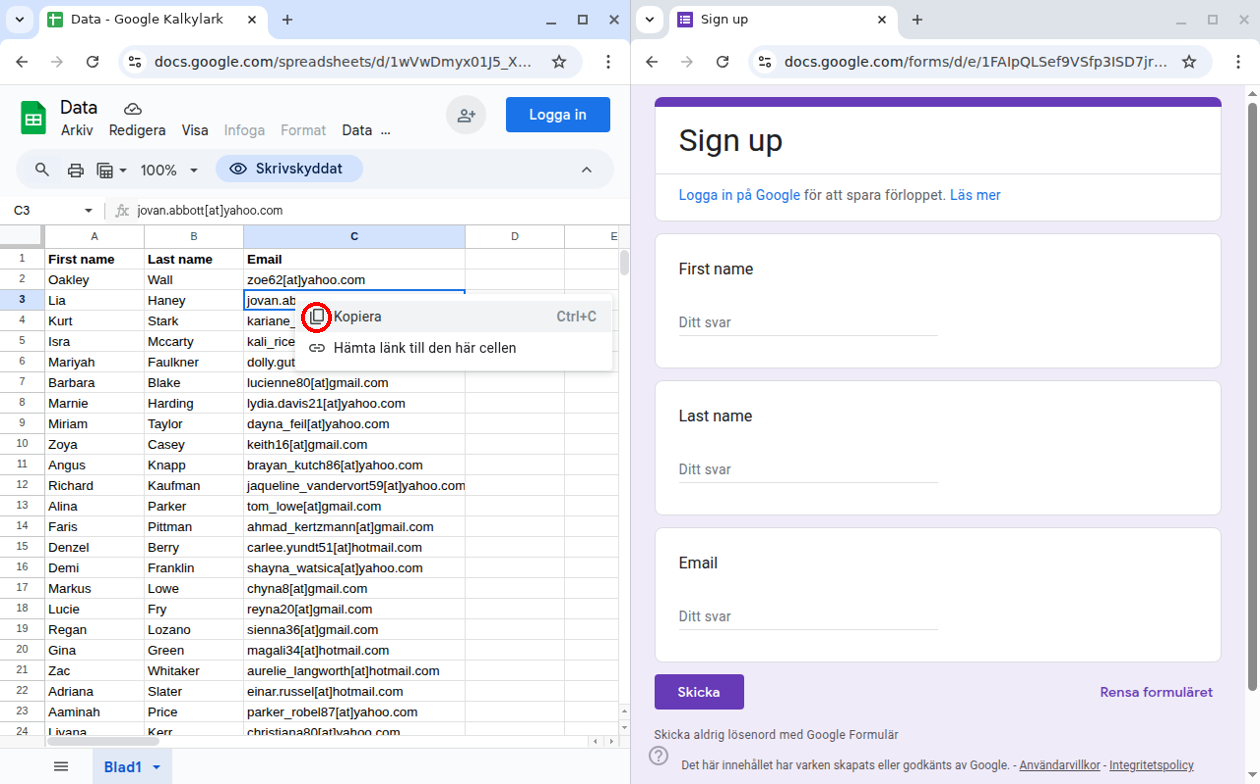

In [29]:
BASE_URL = "http://34.7.85.95:8000/v1"
API_KEY = "EMPTY"
MODEL = "Hcompany/Holo1.5-3B"

client = OpenAI(
    base_url=BASE_URL,
    api_key=API_KEY
)

chat_completion = client.chat.completions.create(
    model=MODEL,
    messages=build_messages(
        task="Click 'Kopiera' in the open context menu.",
        image=image,
        image_format="JPEG"
    ),
    #messages=build_navigation_task_messages(
    #    task="Click 'Kopiera' in the open context menu.",
    #    image=image,
    #    image_format="JPEG"
    #),
    #extra_body={
    #    "guided_json": ClickElementAction.model_json_schema(),
    #},
    temperature=0
)

print(chat_completion.choices[0].message.content)
click = ClickAbsoluteAction(**json.loads(chat_completion.choices[0].message.content))
#print(click)

# Make a copy of the original image
image_with_circle = image.copy()
draw = ImageDraw.Draw(image_with_circle)
center_x, center_y = click.x, click.y
radius = 15  # radius of the circle
left_up_point = (center_x - radius, center_y - radius)
right_down_point = (center_x + radius, center_y + radius)
draw.ellipse([left_up_point, right_down_point], outline="red", width=4)
image_with_circle